# **Training a Graph Attention Network (GAT) on the Cora Citation Dataset**

In this notebook, we explore the task of classifying scientific papers in the Cora citation network — a classic benchmark where each paper is represented as a node and citation links form the edges of the graph. Every node comes with a feature vector and a research-topic label that we aim to predict.

We focus on the **Graph Attention Network (GAT)**, an architecture that learns to assign different importance to each neighbor during message passing. This attention mechanism allows the model to capture more nuanced structure in the graph and highlight the most informative connections.

The notebook will walk through the full workflow:

1. loading and inspecting the dataset,
2. visualizing the graph,
3. defining and implementing the GAT model,
4. training and evaluating it,
5. examining useful practices and interpreting attention weights.

In [44]:
!pip install torch_geometric

In [45]:
# --- Imports & Setup ---

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch.optim as optim
import plotly.graph_objects as go
import pandas as pd
from sklearn.decomposition import PCA

In [46]:
# Fix all random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [47]:
# --- Load the Cora dataset and inspect its structure ---

from torch_geometric.datasets import Planetoid

# Load the dataset
dataset = Planetoid(root="./data", name="Cora")
data = dataset[0]

print("=== Basic Dataset Info ===")
print(f"Number of nodes:        {data.num_nodes}")
print(f"Number of edges:        {data.num_edges}")
print(f"Number of features:     {data.num_features}")
print(f"Number of classes:      {dataset.num_classes}")
print(f"Feature matrix shape:   {data.x.shape}")

print("\n=== Train/Val/Test Splits ===")
print(f"Training nodes:   {int(data.train_mask.sum())}")
print(f"Validation nodes: {int(data.val_mask.sum())}")
print(f"Test nodes:       {int(data.test_mask.sum())}")

=== Basic Dataset Info ===
Number of nodes:        2708
Number of edges:        10556
Number of features:     1433
Number of classes:      7
Feature matrix shape:   torch.Size([2708, 1433])

=== Train/Val/Test Splits ===
Training nodes:   140
Validation nodes: 500
Test nodes:       1000


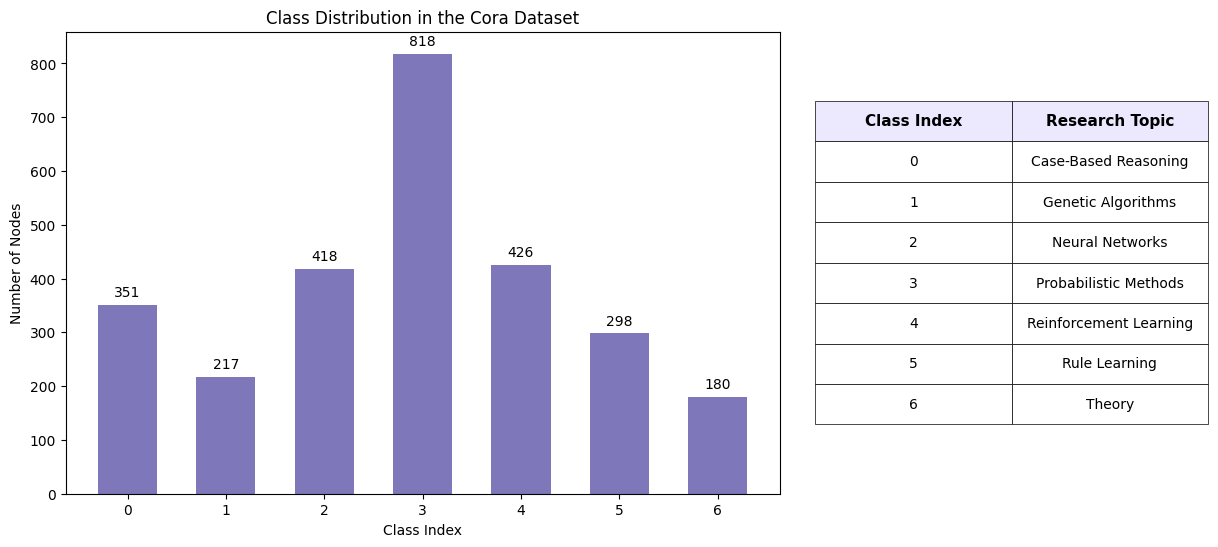

In [48]:
# Visualizations for Class Distribution Plot

labels = data.y.numpy()
num_classes = dataset.num_classes

fig, ax = plt.subplots(figsize=(12, 6))  # wider to fit a bigger table

# --- Main bar plot ---
unique, counts = np.unique(labels, return_counts=True)
ax.bar(unique, counts, width=0.6, color="#7E77B9")

ax.set_xticks(unique)
ax.set_xlabel("Class Index")
ax.set_ylabel("Number of Nodes")
ax.set_title("Class Distribution in the Cora Dataset")

# Add counts above bars
for cls, count in zip(unique, counts):
    ax.text(cls, count + 10, str(count),
            ha="center", va="bottom", fontsize=10)

# --- Class names legend on RIGHT ---
class_names = [
    "Case-Based Reasoning",
    "Genetic Algorithms",
    "Neural Networks",
    "Probabilistic Methods",
    "Reinforcement Learning",
    "Rule Learning",
    "Theory",
]

table_data = [[i, class_names[i]] for i in unique]

# Create a visually pleasing table
table = plt.table(
    cellText=table_data,
    colLabels=["Class Index", "Research Topic"],
    cellLoc="center",
    loc="right",
    bbox=[1.05, 0.15, 0.55, 0.7],   # wider table: width = 0.55
)

# Style improvements
table.auto_set_font_size(False)
table.set_fontsize(10)

# Improve spacing
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    cell.PAD = 0.35  # add padding inside cells

# Header styling
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # header row
        cell.set_facecolor("#ECE9FF")
        cell.set_fontsize(11)
        cell.set_text_props(weight="bold")

# Make space for the table
plt.subplots_adjust(right=0.72)

plt.show()


In [49]:
# 1) Build a NetworkX graph (same as before)
G = nx.Graph()
edge_index = data.edge_index.numpy()

for src, dst in edge_index.T:
    G.add_edge(int(src), int(dst))

# 2) PCA on node features
X = data.x.numpy()
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

labels = data.y.numpy()

# 3) Map class index -> research topic name
class_names = [
    "Case-Based Reasoning",     # 0
    "Genetic Algorithms",       # 1
    "Neural Networks",          # 2
    "Probabilistic Methods",    # 3
    "Reinforcement Learning",   # 4
    "Rule Learning",            # 5
    "Theory",                   # 6
]

topics = [class_names[int(c)] for c in labels]

# 4) (Optional) sample some edges to draw in the background
num_edges_to_plot = 600
edges = list(G.edges())
num_edges_to_plot = min(num_edges_to_plot, len(edges))
edge_indices = np.random.choice(len(edges), size=num_edges_to_plot, replace=False)

edge_x = []
edge_y = []
for idx in edge_indices:
    u, v = edges[idx]
    x0, y0 = X_reduced[u]
    x1, y1 = X_reduced[v]
    edge_x += [x0, x1, None]   # None breaks the line between segments
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=0.3, color="rgba(80,80,80,0.3)"),
    hoverinfo="skip",
    showlegend=False,
)

# 5) Node scatter with hover info
node_trace = go.Scatter(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    mode="markers",
    marker=dict(
        size=6,
        color=labels,
        colorscale="Turbo",
        showscale=True,
        colorbar=dict(title="Class index"),
    ),
    # what appears on hover
    hovertemplate=(
        "<b>Paper ID</b>: %{customdata[0]}<br>"
        "<b>Class index</b>: %{customdata[1]}<br>"
        "<b>Topic</b>: %{customdata[2]}<extra></extra>"
    ),
    customdata=np.stack([np.arange(len(labels)), labels, topics], axis=1),
    name="Nodes",
)

fig = go.Figure(data=[edge_trace, node_trace])

fig.update_layout(
    title="Cora Graph Visualization (PCA on node features)",
    xaxis_title="PCA component 1",
    yaxis_title="PCA component 2",
    width=900,
    height=650,
    plot_bgcolor="white",
)

fig.show()

# Save as HTML to embed in your site
fig.write_html("cora_pca_interactive.html")

### Basic expression of **Graph Attention Network (GAT)** layer

$$
\mathbf{h}_v^{(l)} = \sigma \Big( \sum_{u \in \mathcal{N}(v)} \alpha_{vu} \mathbf{W}^{(l)} \mathbf{h}_u^{(l-1)} \Big)
$$


$$
\mathbf{h}_v^{(l)}: \text{new representation of node } v \text{ at layer } l
$$

$$
\mathbf{h}_u^{(l-1)}: \text{embedding of neighboring node } u \text{ from the previous layer}
$$

$$
\alpha_{vu}: \text{attention coefficient for edge } v \to u
$$

$$
\mathbf{W}^{(l)}: \text{learnable weight matrix of layer } l
$$

$$
\mathcal{N}(v): \text{set of neighbors of node } v
$$

#### Attention coefficient computation

$$
\alpha_{ij} = \frac{\exp(\text{LeakyReLU}(a^T [Wh_i || Wh_j]))}{\sum_{k \in \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T [Wh_i || Wh_k]))}
$$

(In `torch_geometric.nn.GATConv`, this is implemented internally)



In [50]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_res = x
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # optional residual for first layer if dimensions match
        if x_res.shape[1] == x.shape[1]:
            x = x + x_res
        x = self.gat2(x, edge_index)
        return x

In [51]:
model = GAT(dataset.num_features, 8, dataset.num_classes).to(device)  # hidden_channels=8, heads=8
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

train_losses = []
val_accs = []

best_val_acc = 0
patience = 10
counter = 0
best_model_state = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum() / data.val_mask.sum()
        val_accs.append(val_acc.item())

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Early stopping at epoch 18


In [52]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
print("Test Accuracy:", float(test_acc))

Test Accuracy: 0.7720000147819519


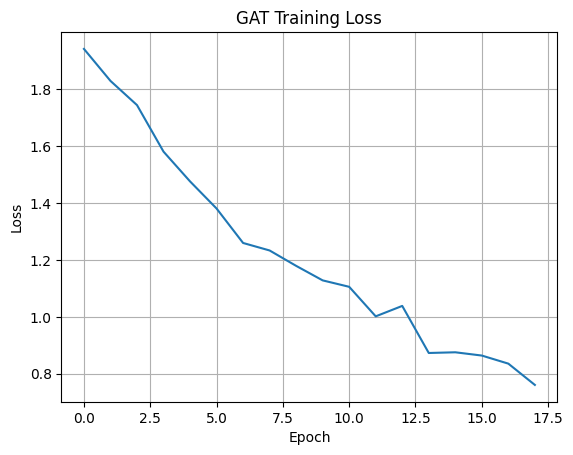

In [53]:
plt.plot(train_losses)
plt.title("GAT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


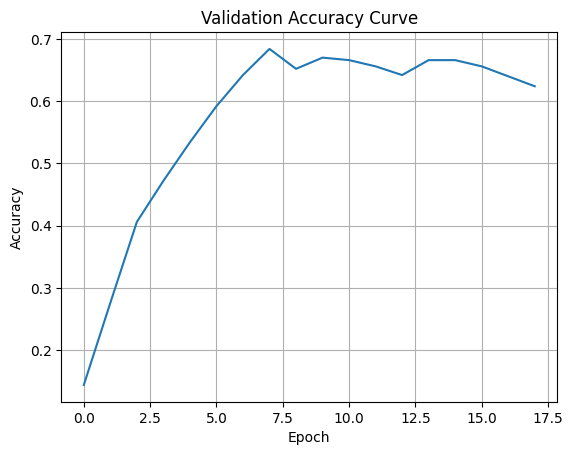

In [54]:
plt.plot(val_accs)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


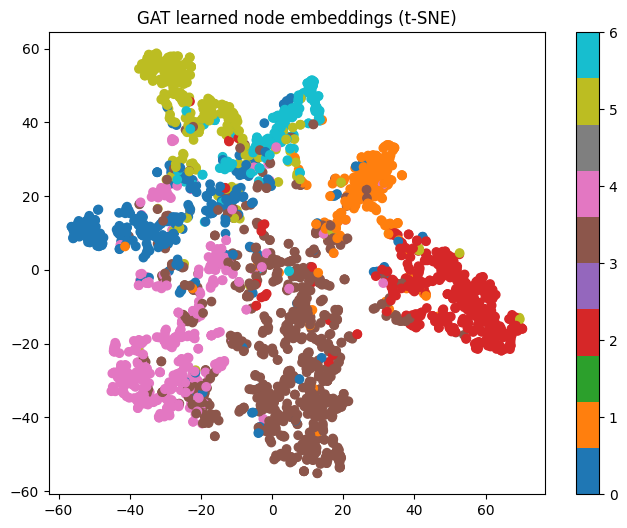

In [55]:
from sklearn.manifold import TSNE

model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate='auto')
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=data.y.cpu(), cmap="tab10")
plt.title("GAT learned node embeddings (t-SNE)")
plt.colorbar()
plt.show()


Some experiments with model and training parameters were performed to tune the GAT architecture. I tested different values of `weight_decay` (5e-4, 1e-3), learning rates (`lr = 0.005` and `0.001`), early-stopping patience (10 and 20), as well as architectural parameters such as `hidden_channels` (4, 8) and the number of attention heads (4, 8).
Based on these experiments, the most stable configuration was selected, providing the best validation accuracy without overfitting.
